In [12]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings("ignore")

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transform import calculate_distance_matrix, od_matrix_to_links, load_graph_geometry, get_accessibility_isochrone
from ilp_solver import ilp_distribute
from dcgm import dcgm_distribute
from dcgm_custom import custom_dcgm_distribute
from gnn import ProvisionSparseDataset

from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
# territorial units
municipalities = gpd.read_file("data/mo.geojson")
blocks = gpd.read_file("data/blocks.geojson")

# houses and facilities
houses = gpd.read_file("data/houses.geojson").set_index("internal_id")
facilities = gpd.read_file("data/facilities_kindergartens.geojson").set_index("internal_id")

houses = houses.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)
facilities = facilities.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)

# road network
network = nx.read_graphml("data/road_network.graphml", node_type=int)
road_network = load_graph_geometry(network, node=True)

In [3]:
# calculate 600 m walk isohrones 

facilities_loc = facilities[facilities["municipality_id"].isin([88, 72, 21])]
isochrones = []

limit = 600
edge_weight = "length_meter"
crs = 32636
for index, row in tqdm(facilities_loc.iterrows(), total=facilities_loc.shape[0]):
    point = (row["geometry"].xy[0][0], row["geometry"].xy[1][0])
    isochrone = get_accessibility_isochrone(road_network, "walk", point[0], point[1], limit, edge_weight, crs)
    isochrones.append(isochrone)

df_isochrones = pd.concat(isochrones)
united_isochrones = gpd.GeoSeries(df_isochrones["geometry"].to_crs(32636).unary_union)

  0%|          | 0/43 [00:00<?, ?it/s]

In [4]:
DM = calculate_distance_matrix(network, houses, facilities)
OD_ILP = ilp_distribute(houses, facilities, DM, selection_range=600)

  0%|          | 0/21464 [00:00<?, ?it/s]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [ ]:
# ! Doesn't converge
OD_DCGM = dcgm_distribute(houses, facilities, DM)

In [5]:
OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, 600, p=0)

100%|██████████| 9/9 [00:52<00:00,  5.79s/it]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [6]:
# merge results into dfs

dist = 600

houses["provision_ilp"] = OD_ILP[DM <= dist].fillna(0).sum() / houses["demand"]
houses["provision_dcgm"] = OD_СDCGM[DM <= dist].fillna(0).sum() / houses["demand"]
houses["supported_demand_ilp"] = OD_ILP[DM <= dist][houses.index].fillna(0).sum()
houses["supported_demand_dcgm"] = OD_СDCGM[DM <= dist][houses.index].fillna(0).sum()
houses["left_demand_ilp"] = houses["demand"] - houses["supported_demand_ilp"]
houses["left_demand_dcgm"] = houses["demand"] - houses["supported_demand_dcgm"]

facilities["left_capacity_ilp"] = facilities["capacity"] - OD_ILP[DM <= 600].fillna(0).sum(1)
facilities["left_capacity_dcgm"] = facilities["capacity"] - OD_СDCGM[DM <= 600].fillna(0).sum(1)

houses_aggr = houses.groupby(["municipality_id"]).sum()
municipalities = municipalities.join((houses_aggr["supported_demand_ilp"] / houses_aggr["demand"]).rename("provision_ilp"), on="id")
municipalities = municipalities.join((houses_aggr["supported_demand_dcgm"] / houses_aggr["demand"]).rename("provision_dcgm"), on="id")

edges_ilp = od_matrix_to_links(OD_ILP, DM, houses, facilities)
edges_dcgm = od_matrix_to_links(OD_СDCGM, DM, houses, facilities)

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

In [41]:
houses.to_file("output/houses.geojson")
facilities.to_file("output/facilities.geojson")
municipalities.to_file("output/mo_aggr.geojson")

edges_ilp.to_file("output/edges_ilp.geojson")
edges_dcgm.to_file("output/edges_dcgm.geojson")

In [7]:
def set_color_map(bins, patches, color_palette):
    cm = plt.cm.get_cmap(color_palette)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

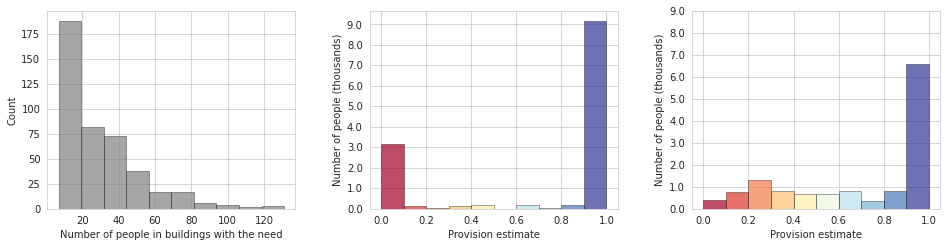

In [8]:
dist = 600
houses_loc = houses[houses["municipality_id"].isin([88, 72, 21])]

fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

n, bins, patches = ax1.hist(houses_loc["demand"], 10, alpha = 0.7, color='grey', edgecolor='black', linewidth=0.5)
ax1.set_xlabel("Number of people in buildings with the need")
ax1.set_ylabel("Count")

ax2_n, bins, patches = ax2.hist(houses_loc["provision_ilp"], 10, alpha = 0.7, weights=houses_loc["demand"], edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax2.set_yticks(np.arange(0, max(ax2_n) + 1, 1000))
ax2.set_yticklabels([x / 1000 for x in ax2.get_yticks().tolist()])
ax2.set_xlabel("Provision estimate")
ax2.set_ylabel("Number of people (thousands)")

ax3_n, bins, patches = ax3.hist(houses_loc["provision_dcgm"], 10, alpha = 0.7, weights=houses_loc["demand"], edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax3.set_yticks(np.arange(0, max(ax2_n)+1, 1000))
ax3.set_yticklabels([x / 1000 for x in ax3.get_yticks().tolist()])
ax3.set_xlabel("Provision estimate")
ax3.set_ylabel("Number of people (thousands)")

plt.show()

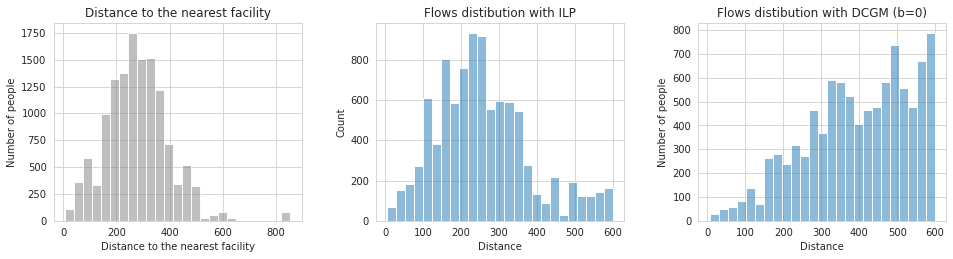

In [9]:
dist = 600
houses_loc = houses[houses["municipality_id"].isin([88, 72, 21])]

fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

distances_ilp = DM[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
distances_ilp = distances_ilp[~np.isnan(distances_ilp)]
flows_ilp = OD_ILP[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
flows_ilp = flows_ilp[~np.isnan(flows_ilp)]

f_dist_nearest = pd.DataFrame({"distance": list(DM.min().loc[houses_loc.index]), "flows": houses["demand"].loc[houses_loc.index]})
f_dist_dcgm = pd.DataFrame({"distance": distances_dcgm[distances_dcgm<=600], "flows":flows_dcgm[distances_dcgm<=600]})
f_dist_ilp = pd.DataFrame({"distance": distances_ilp[distances_ilp<=600], "flows":flows_ilp[distances_ilp<=600]})

sns.histplot(data=f_dist_nearest, x="distance", bins=25, alpha = 0.5, ax=ax1, kde=False, color="gray", weights='flows')
ax1.set_title("Distance to the nearest facility")
ax1.set_xlabel("Distance to the nearest facility")
ax1.set_ylabel("Number of people")

sns.histplot(data=f_dist_ilp, x="distance", bins=25, alpha = 0.5, ax=ax2, kde=False, weights='flows')
ax2.set_title("Flows distibution with ILP")
ax2.set_xlabel("Distance")
ax3.set_ylabel("Number of people")

sns.histplot(data=f_dist_dcgm, x="distance", bins=25, alpha = 0.5, ax=ax3, kde=False, weights='flows')
ax3.set_title("Flows distibution with DCGM (b=0)")
ax3.set_xlabel("Distance")
ax3.set_ylabel("Number of people")

plt.show()

100%|██████████| 9/9 [00:58<00:00,  6.55s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [01:00<00:00,  6.68s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:57<00:00,  6.36s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:56<00:00,  6.22s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:55<00:00,  6.17s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:57<00:00,  6.37s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


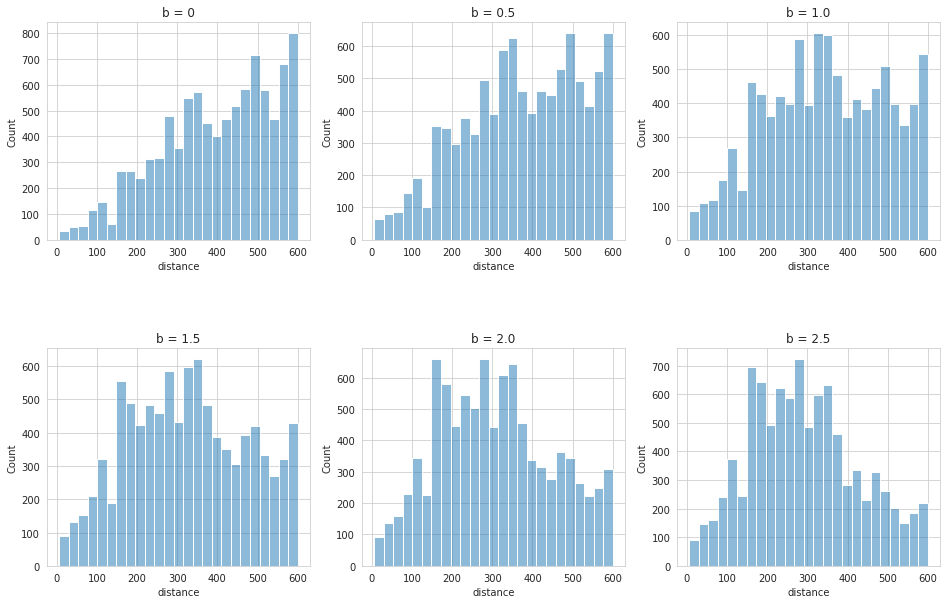

In [11]:
fig = plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=0.5)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

p = 0

houses_loc = houses[houses["municipality_id"].isin([88, 72, 21])]
for i in range(1, 7):
    OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, 600, p=p)

    distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
    flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

    f_dist_dcgm = pd.DataFrame({"distance": distances_dcgm[distances_dcgm<=600], "flows":flows_dcgm[distances_dcgm<=600]})

    sns.histplot(data=f_dist_dcgm, x="distance", bins=25, alpha = 0.5, ax=locals()["ax" + str(i)], kde=False, weights='flows')
    locals()["ax" + str(i)].set_title("b = " + str(p))

    p += 0.5

plt.show()

  0%|          | 0/21464 [00:00<?, ?it/s]

  0%|          | 0/21464 [00:00<?, ?it/s]

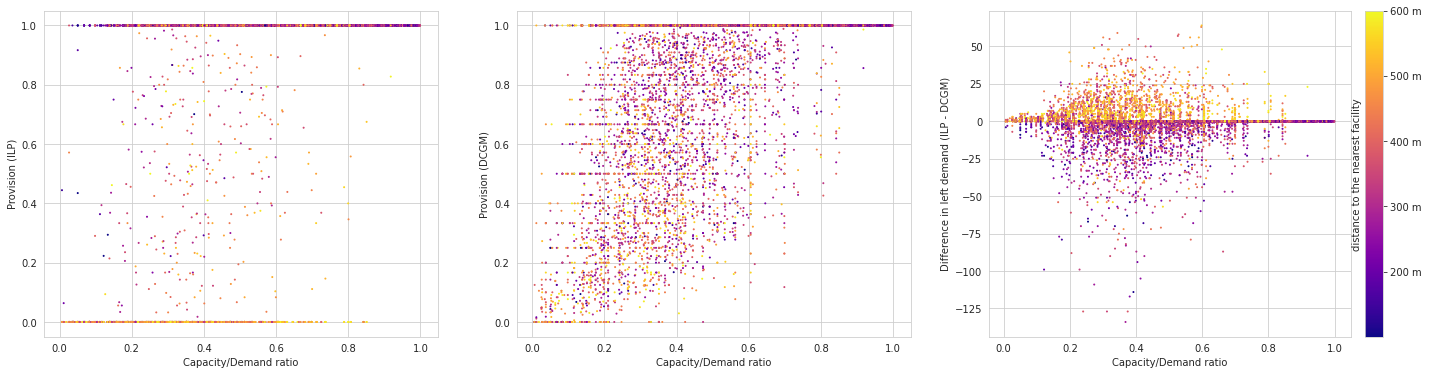

In [13]:
diff = houses["left_demand_ilp"] - houses["left_demand_dcgm"]

dm = (DM <= dist)
demand_around = dm.progress_apply(lambda x: houses['demand'][dm.loc[facilities["capacity"][x].index].any()].sum())
sum_capacity = dm.progress_apply(lambda x: facilities["capacity"][x].sum())
ratio = sum_capacity / demand_around

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
color_palette = plt.cm.get_cmap("plasma")
distances = list(DM.min()[ratio < 1])
color_pointer = [i / max(distances) for i in distances]

ax1.set_xlabel("Capacity/Demand ratio")
ax1.set_ylabel("Provision (ILP)")
a = ax1.scatter(ratio[ratio < 1], houses["provision_ilp"][ratio < 1], c=color_pointer, cmap=color_palette, s=1)
# ax1.legend(handles=a.legend_elements()[0], labels=color_class)

ax2.set_xlabel("Capacity/Demand ratio")
ax2.set_ylabel("Provision (DCGM)")
b = ax2.scatter(ratio[ratio < 1], houses["provision_dcgm"][ratio < 1], c=color_pointer, cmap=color_palette, s=1)
# ax2.legend(handles=b.legend_elements()[0], labels=color_class)

ax3.set_xlabel("Capacity/Demand ratio")
ax3.set_ylabel("Difference in left demand (ILP - DCGM)")
c = ax3.scatter(ratio[ratio < 1], diff[ratio < 1], c=color_pointer, cmap=color_palette, s=1)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.2)

cbar = fig.colorbar(a, cax=cax, orientation='vertical')
cbar.set_label("distance to the nearest facility", labelpad=-70)
cbar.set_ticklabels([str(d) + " m" for d in range(100, int(max(distances)) + 1, 100)])
# ax3.legend(handles=c.legend_elements()[0], labels=color_class)

In [5]:
dataset = ProvisionSparseDataset("data/pyg_data")

Processing...
Done!
